In [9]:
%pip install numpy scikit-learn requests matplotlib.pyplot seaborn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


In [10]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
response = requests.get("https://data.cityofnewyork.us/resource/2bnn-yakx.json")
response_json = response.json()
df = pd.DataFrame(response_json)

# Custom function to parse the 'violation_time' column
def parse_violation_time(time_str):
    try:
        if time_str[-1] == 'A':
            new_time_str=time_str + 'M'
            return datetime.strptime(new_time_str, '%I%M%p')
        elif time_str[-1] == 'P':
            new_time_str=time_str + 'M'
            if time_str[:2] <= '12':
                return datetime.strptime(new_time_str, '%I%M%p')
            else:
                return datetime.strptime(new_time_str, '%I%M%p')
        elif len(time_str) == 4:
            return datetime.strptime(new_time_str, '%H%M')
        else:
            return pd.NaT
    except ValueError:
        return pd.NaT

df['violation_time'] = df['violation_time'].apply(parse_violation_time)
df['vehicle_year'] = (df['vehicle_year']).astype(int)
df['violation_time'].head(10)

0   1900-01-01 01:43:00
1   1900-01-01 16:00:00
2   1900-01-01 12:11:00
3   1900-01-01 12:17:00
4   1900-01-01 12:07:00
5   1900-01-01 10:37:00
6   1900-01-01 13:01:00
7   1900-01-01 18:02:00
8   1900-01-01 08:14:00
9   1900-01-01 12:38:00
Name: violation_time, dtype: datetime64[ns]

Text(0, 0.5, 'Number of Occurrences by Postal code')

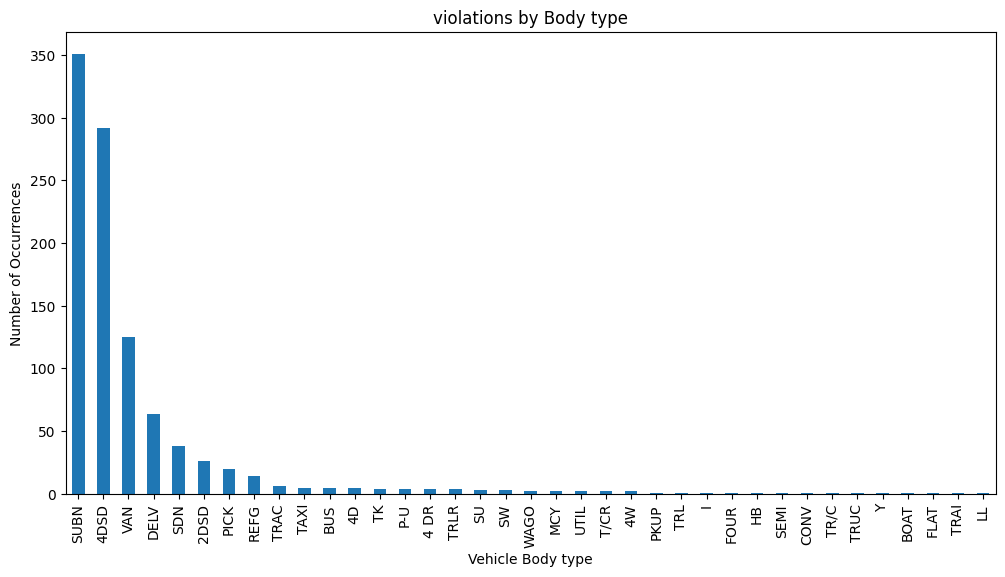

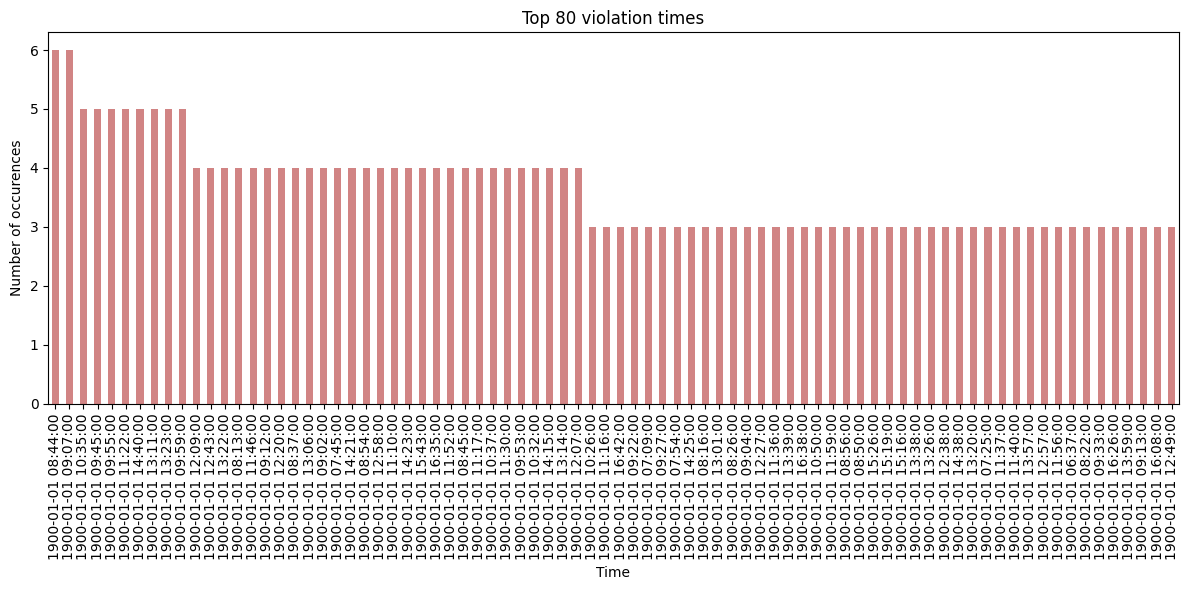

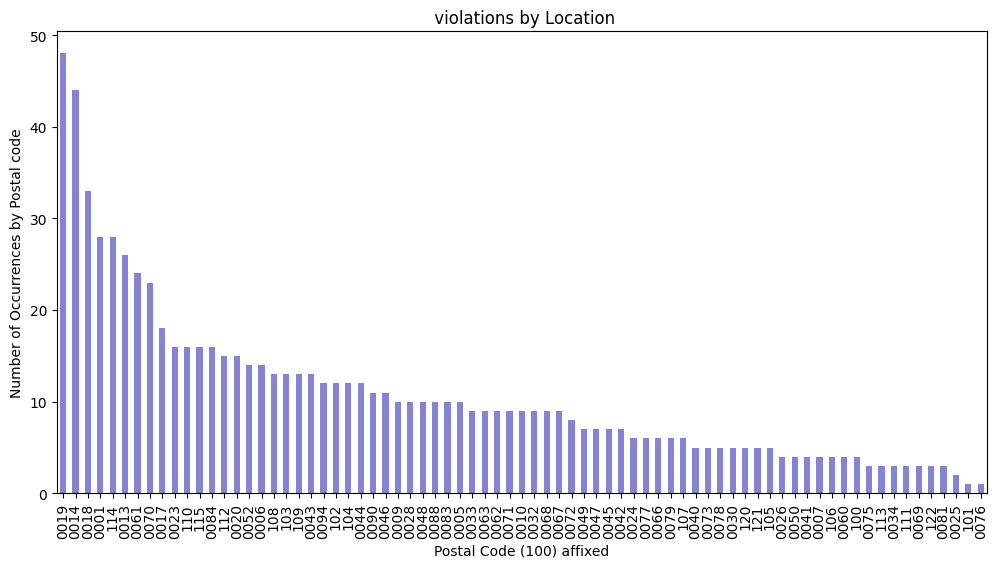

In [11]:
plt.figure(figsize=(12,6))
vehicle_counts=df['vehicle_body_type'].value_counts()
vehicle_counts.plot(kind='bar')
plt.title("violations by Body type")
plt.xlabel('Vehicle Body type')
plt.ylabel("Number of Occurrences")


#getting the first top 10 times and their counts
top_times= df['violation_time'].value_counts().head(80)
plt.figure(figsize=(12,6))
top_times.plot(kind='bar', color=(0.7, 0.2, 0.2, 0.6))
plt.title("Top 80 violation times")
plt.xlabel("Time")
plt.ylabel("Number of occurences")
plt.tight_layout()

plt.figure(figsize=(12,6))
vehicle_counts=df['violation_location'].value_counts()
vehicle_counts.plot(kind='bar', color=(0.2, 0.2, 0.7, 0.6))
plt.title(" violations by Location")
plt.xlabel('Postal Code (100) affixed')
plt.ylabel("Number of Occurrences by Postal code")





The dataset caputures ticket given to car for the fiscal year 2023, we looked into the violation times, what body types we more substible to being ticketed and in what county said tickets were given.
Our main training data features are {violation time, location and bodytypes}
## **Our hypothesis: Given a car of 'bodytype', located in a certain county at some predefined time, could we train a machine to determine the likehood that said vehicle being ticketed.**





In [12]:
#drawing a scaatter plot of the bodytypes with  time 